In [1]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()

/tmp/ipykernel_452/2182241943.py:3: RuntimeWarning: Failed to import dependencies for application/vnd.jupyter.widget-view+json representation. (ModuleNotFoundError: No module named 'ipywidgets')
  sc.logging.print_header()


Component,Info
Python,"3.10.18 | packaged by conda-forge | (main, Jun 4 2025, 14:45:41) [GCC 13.3.0]"
OS,Linux-5.15.0-1044-aws-x86_64-with-glibc2.27
CPU,"16 logical CPU cores, x86_64"
GPU,No GPU found
Updated,2025-08-15 00:35
Dependency,Version
debugpy,1.8.16
ipython,8.37.0
pillow,11.3.0
executing,2.2.0


In [3]:
results_file = "write/pbmc3k.h5ad"  # the file that will store the analysis results

In [5]:
adata = sc.read_10x_mtx(
    "../data/filtered_gene_bc_matrices/hg19/",  
    # the directory with the `.mtx` file
    var_names="gene_symbols",  
    # use gene symbols for the variable names (variables-axis index)
    cache=True,  
    # write a cache file for faster subsequent reading
)

... writing an h5ad cache file to speedup reading next time


In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


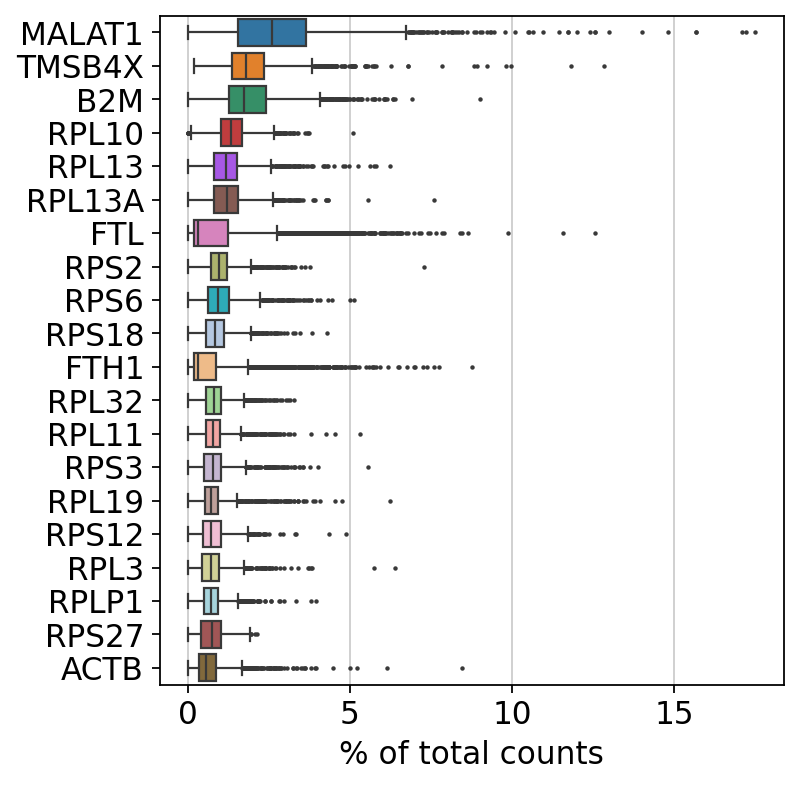

In [7]:
# preprocessing

sc.pl.highest_expr_genes(adata, n_top=20)

In [8]:
# basic filtering

sc.pp.filter_cells(adata, min_genes=200)  # this does nothing, in this specific case
sc.pp.filter_genes(adata, min_cells=3)
adata

filtered out 19024 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

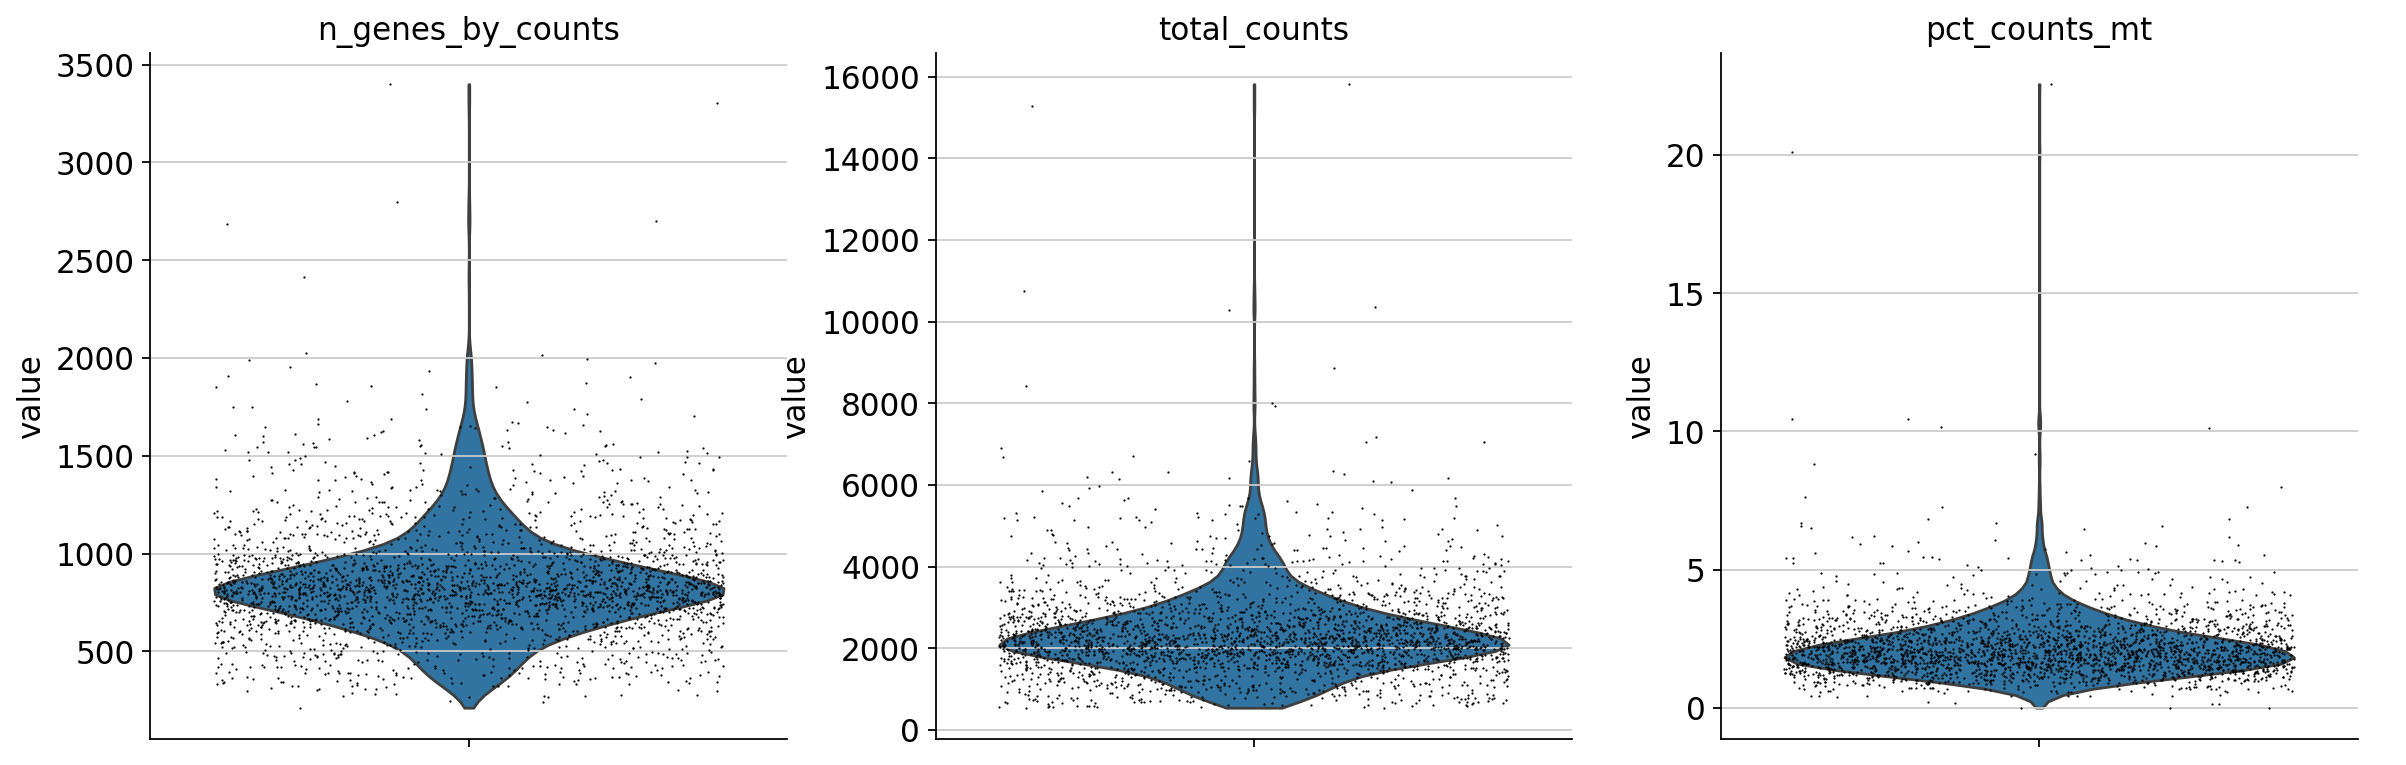

In [9]:
## rule out mt genes

adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

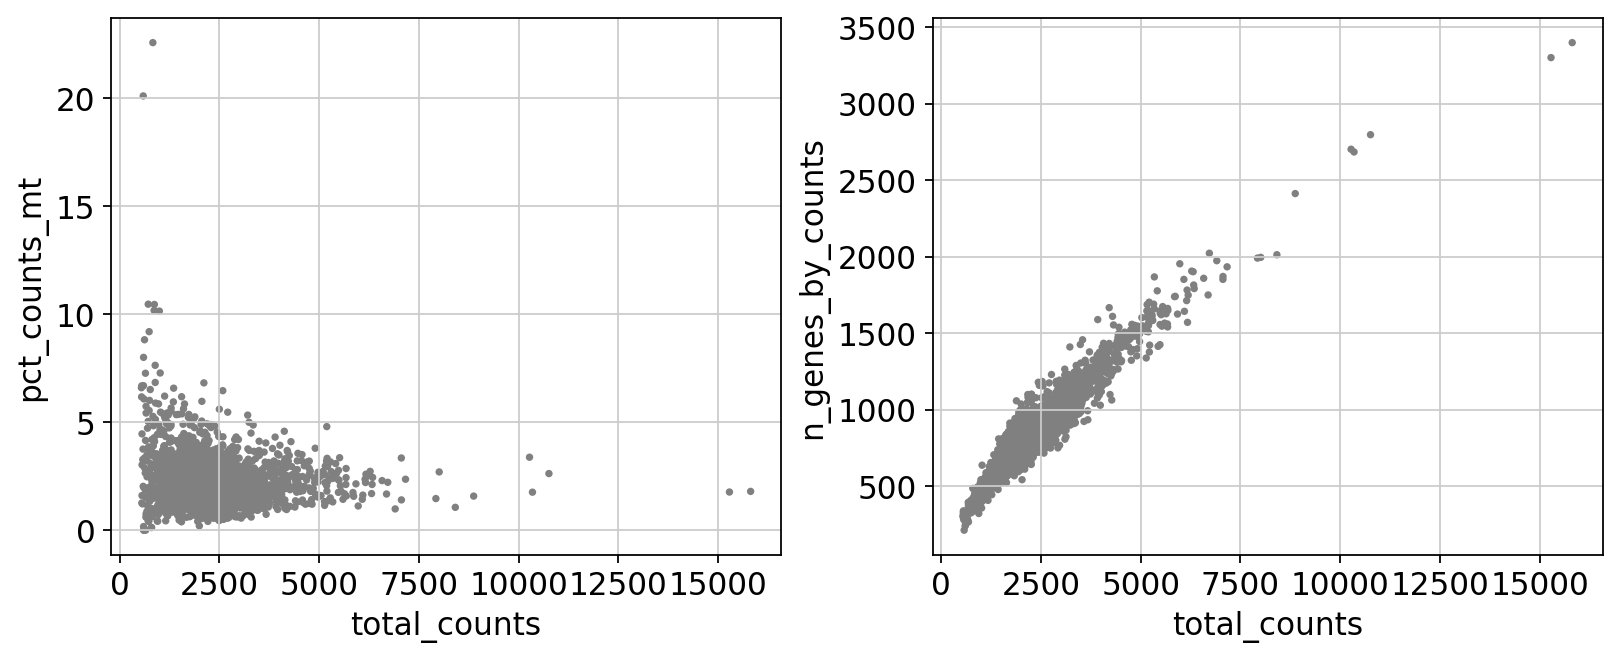

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show=False, ax=axs[0])
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", show=False, ax=axs[1]);

In [12]:
adata = adata[
    (adata.obs.n_genes_by_counts < 2500)
    & (adata.obs.n_genes_by_counts > 200)
    & (adata.obs.pct_counts_mt < 5),
    :,
].copy()
adata.layers["counts"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [14]:
adata.raw = adata.copy()

from pathlib import Path
Path("cache").mkdir(exist_ok = True)
adata.write("cache/pbmc3k_tut.h5ad")